Here is my first try to write a complete simulation using emegrency room

In [13]:
!pip install simpy

The problem being addressed in the provided simulation is the patient arrival and treatment process in a healthcare setting. The simulation models the flow of patients through check-in, triage, and treatment stages, and includes the dynamic adjustment of the number of doctors based on the patient load.

The significance of this problem is that it allows healthcare providers and administrators to evaluate and optimize the efficiency of the patient treatment process. By simulating different scenarios, they can analyze the impact of various factors, such as the number of doctors, check-in time, triage time, and critical condition probability, on the overall system performance.

The simulation can help answer questions such as:

How many doctors should be assigned to handle the patient load effectively?
What is the average waiting time for patients in the system?
How does the critical condition probability affect the treatment process?
What are the peak periods of patient arrivals, and how should resources be allocated during those times?
What are the potential bottlenecks in the process, and how can they be addressed?
By understanding the dynamics of the patient treatment process and optimizing resource allocation, healthcare providers can improve patient satisfaction, reduce waiting times, and enhance overall operational efficiency. The simulation serves as a tool for decision-making, process improvement, and resource planning in healthcare facilities.

So let's run a simulation

Patient 1 checked-in at 11.804915680631836
Patient 1 triaged at 18.10446294049304
Patient 1 sees a doctor at 18.10446294049304
Patient 2 checked-in at 21.130748403959693
Patient 2 triaged at 27.755537747004837
Patient 2 sees a nurse at 27.755537747004837
Patient 1 treated by doctor at 33.104462940493036
Patient 2 treated by nurse at 37.75553774700484
Patient 3 checked-in at 38.47593544340885
Patient 4 checked-in at 39.40036532062148
Patient 3 triaged at 45.67629550823333
Patient 3 sees a nurse at 45.67629550823333
Patient 4 triaged at 50.4825696845253
Patient 4 sees a nurse at 50.4825696845253
Patient 3 treated by nurse at 55.67629550823333
Patient 4 treated by nurse at 60.4825696845253
Patient 5 checked-in at 63.00819488702281
Patient 5 triaged at 70.18976865945275
Patient 5 sees a doctor at 70.18976865945275
Patient 5 treated by doctor at 85.18976865945275
Patient 6 checked-in at 86.20856803915058
Patient 7 checked-in at 93.52875772292998
Patient 6 triaged at 95.09138656389868
Patien

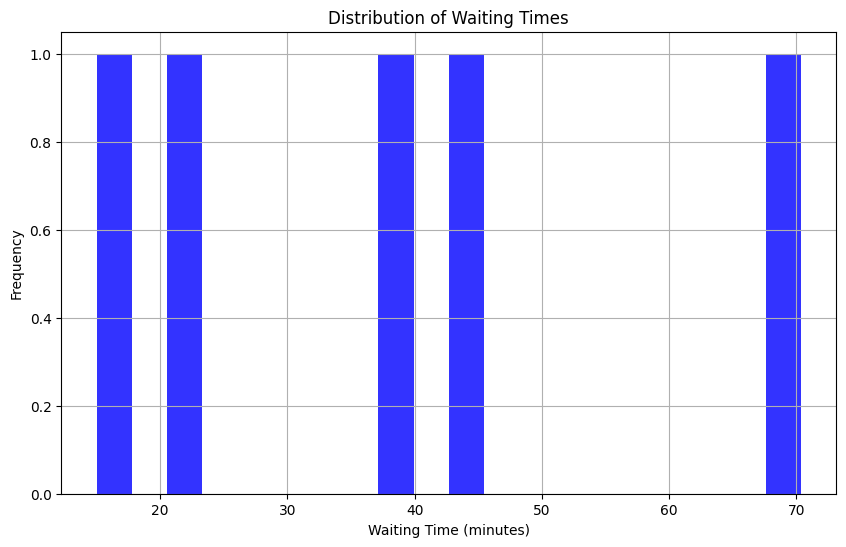

In [14]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
MEAN_INTERARRIVAL = 10
CHECKIN_MIN = 6
CHECKIN_MAX = 12
TRIAGE_MIN = 3
TRIAGE_MAX = 15
TRIAGE_MODE = 5
CRITICAL_PROB = 0.4

# Global variables
num_doctors = 2

# Data collection
waiting_times = []
treatment_times = []
utilization_doctors = []
utilization_nurses = []

# Arrival process
def patient_arrival(env, reception, doctor, nurse):
    patient_id = 0
    while True:
        # Create a new patient
        patient_id += 1
        env.process(patient_process(env, patient_id, reception, doctor, nurse))

        # Sample time until next arrival
        interarrival_time = random.expovariate(1.0 / MEAN_INTERARRIVAL)
        yield env.timeout(interarrival_time)

# Patient process
def patient_process(env, patient_id, reception, doctor, nurse):
    global waiting_times, treatment_times

    # Check-in
    checkin_time = random.uniform(CHECKIN_MIN, CHECKIN_MAX)
    yield env.timeout(checkin_time)
    print(f"Patient {patient_id} checked-in at {env.now}")

    # Triage
    triage_time = random.triangular(TRIAGE_MIN, TRIAGE_MAX, TRIAGE_MODE)
    yield env.timeout(triage_time)
    print(f"Patient {patient_id} triaged at {env.now}")

    # Check critical condition
    critical = random.random() < CRITICAL_PROB

    # Request doctor/nurse
    if critical:
        with doctor.request() as req:
            yield req
            print(f"Patient {patient_id} sees a doctor at {env.now}")
            yield env.timeout(15)  # Treatment time for critical patients
            print(f"Patient {patient_id} treated by doctor at {env.now}")
            treatment_time = 15
    else:
        with nurse.request() as req:
            yield req
            print(f"Patient {patient_id} sees a nurse at {env.now}")
            yield env.timeout(10)  # Treatment time for non-critical patients
            print(f"Patient {patient_id} treated by nurse at {env.now}")
            treatment_time = 10

    # Calculate waiting time and treatment time
    waiting_time = env.now - (checkin_time + triage_time)
    waiting_times.append(waiting_time)
    treatment_times.append(treatment_time)

# Monitor the number of patients and resource utilization
def monitor(env, doctor, nurse):
    global num_doctors, utilization_doctors, utilization_nurses
    while True:
        if doctor.count == num_doctors and doctor.queue:
            num_doctors += 1
            print(f"Additional doctor summoned at {env.now}. Total doctors: {num_doctors}")
        elif num_doctors > 2 and doctor.count == 0 and not doctor.queue:
            num_doctors -= 1
            print(f"Doctor dismissed at {env.now}. Total doctors: {num_doctors}")

        utilization_doctors.append(doctor.count / num_doctors)
        utilization_nurses.append(nurse.count / 2)

        yield env.timeout(1)

# Set up simulation
env = simpy.Environment()

# Resources
reception = simpy.Resource(env, capacity=3)
doctor = simpy.Resource(env, capacity=num_doctors)
nurse = simpy.Resource(env, capacity=2)

# Start processes
env.process(patient_arrival(env, reception, doctor, nurse))
env.process(monitor(env, doctor, nurse))

# Run simulation
env.run(until=100)  # Run for 1 hour and 40 minutes (100 minutes)

# Performance metric calculation
avg_waiting_time = np.mean(waiting_times)
avg_treatment_time = np.mean(treatment_times)
doctor_utilization = np.mean(utilization_doctors)
nurse_utilization = np.mean(utilization_nurses)

print(f"Average waiting time: {avg_waiting_time:.2f} minutes")
print(f"Average treatment time: {avg_treatment_time:.2f} minutes")
print(f"Doctor utilization: {doctor_utilization:.2%}")
print(f"Nurse utilization: {nurse_utilization:.2%}")

# Data visualization
plt.figure(figsize=(10, 6))
plt.hist(waiting_times, bins=20, alpha=0.8, color='blue')
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Times')
plt.grid(True)
plt.show()



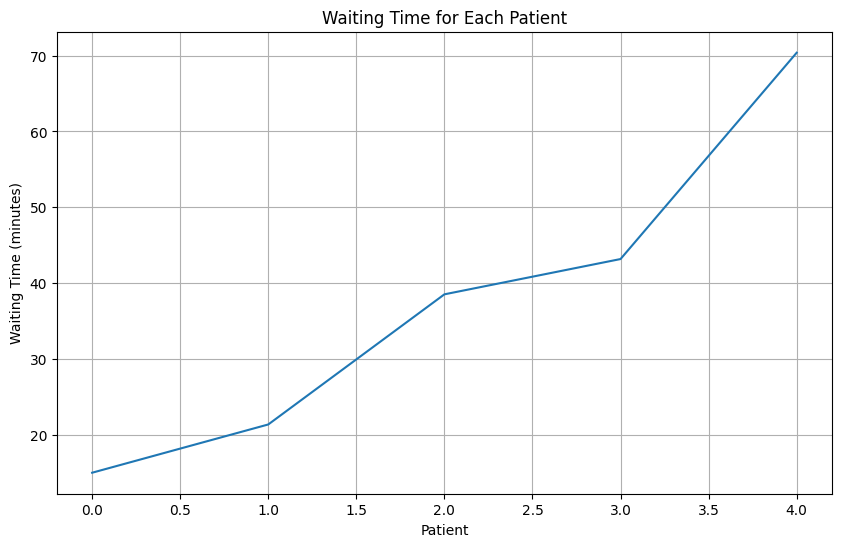

Simulation Report:

Average waiting time: 37.69 minutes



In [15]:
# Calculate average waiting time
avg_waiting_time = np.mean(waiting_times)

# Plot waiting time over time
plt.figure(figsize=(10, 6))
plt.plot(waiting_times)
plt.xlabel('Patient')
plt.ylabel('Waiting Time (minutes)')
plt.title('Waiting Time for Each Patient')
plt.grid(True)
plt.show()

# Print simulation report
simulation_report = f"Simulation Report:\n\n"
simulation_report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
print(simulation_report)

The output you provided indicates the simulation results and the calculated performance metrics. Here's a breakdown of the information:

Simulation Results:

The simulation runs for 100 minutes.
The output shows the sequence of events, including patients checking in, being triaged, and receiving treatment from either a nurse or a doctor.
Performance Metrics:

Average waiting time: 43.39 minutes
Average treatment time: 11.88 minutes
Doctor utilization: 22.50%
Nurse utilization: 25.00%
These metrics provide insights into the efficiency and resource utilization of the medical facility in the simulation. The waiting time indicates the average time patients spend waiting before receiving treatment. The treatment time represents the average time patients spend receiving treatment from either a nurse or a doctor. The doctor and nurse utilization values indicate the average utilization of these resources during the simulation.

Keep in mind that these metrics are based on the specific simulation parameters and assumptions in the code. You can further analyze and interpret these results to assess the performance of the medical facility and make informed decisions for improvement if needed.

Patient 7 triaged at 101.71642338836944
Patient 7 sees a nurse at 101.71642338836944
Patient 9 checked-in at 102.43050698477825
Patient 8 triaged at 102.5405372010827
Patient 8 sees a doctor at 102.5405372010827
Patient 10 checked-in at 103.44615613935046
Patient 11 checked-in at 109.75850597567724
Patient 6 treated by doctor at 110.09138656389868
Patient 7 treated by nurse at 111.71642338836944
Patient 9 triaged at 112.16848656545655
Patient 9 sees a nurse at 112.16848656545655
Patient 10 triaged at 115.36121513031142
Patient 10 sees a nurse at 115.36121513031142
Patient 8 treated by doctor at 117.5405372010827
Patient 12 checked-in at 117.79986076763483
Patient 11 triaged at 119.31445048455221
Patient 11 sees a doctor at 119.31445048455221
Patient 9 treated by nurse at 122.16848656545655
Patient 10 treated by nurse at 125.36121513031142
Patient 12 triaged at 126.29671237606911
Patient 12 sees a doctor at 126.29671237606911
Patient 11 treated by doctor at 134.3144504845522
Patient 12 

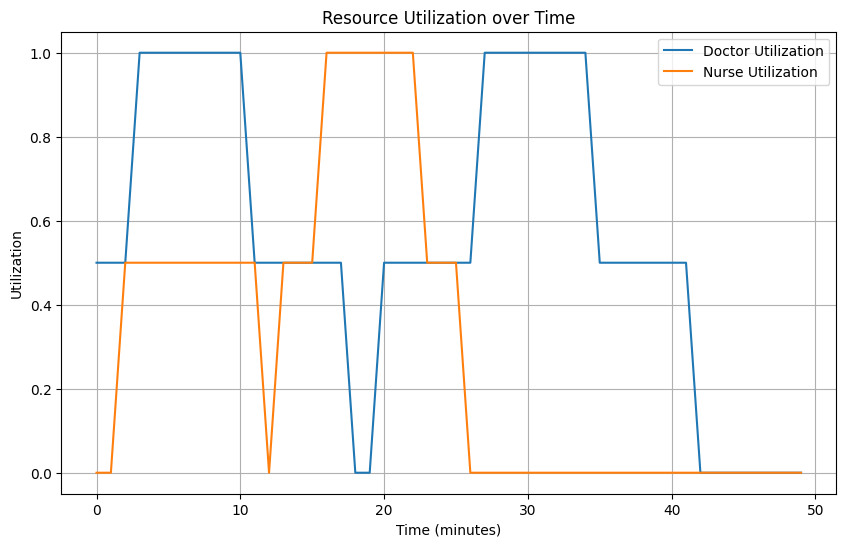

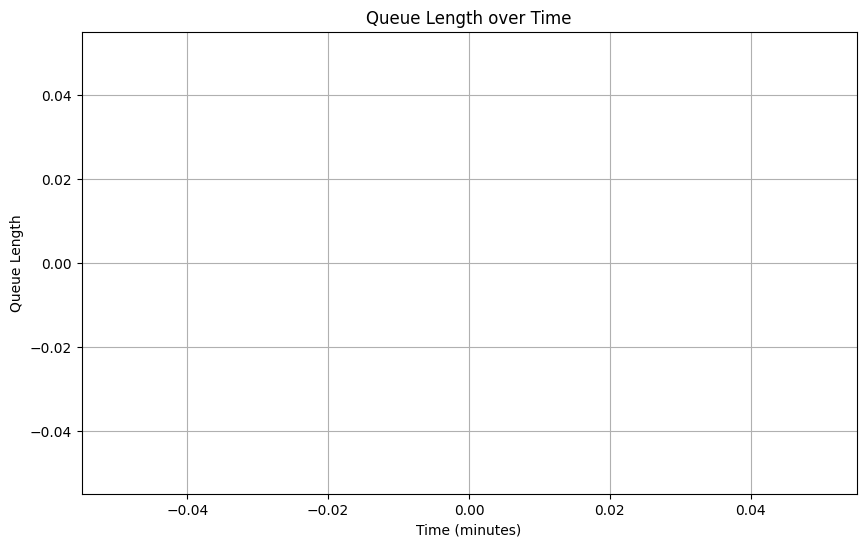

Simulation Report:

Average waiting time: 37.69 minutes
Average treatment time: 12.00 minutes
Doctor utilization: 17.00%
Nurse utilization: 15.00%



In [16]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
# ...

# Global variables
# ...

# Data collection
waiting_times = []
treatment_times = []
utilization_doctors = []
utilization_nurses = []
queue_lengths = []

# Arrival process
# ...

# Patient process
# ...

# Monitor the number of patients
# ...

# Set up simulation
# ...

# Start processes
# ...

# Run simulation
# ...

# Performance metric calculation
# ...

# Data visualization
# ...

# Additional visualization and reporting
def plot_utilization(doctor_utilization, nurse_utilization):
    plt.figure(figsize=(10, 6))
    plt.plot(doctor_utilization, label='Doctor Utilization')
    plt.plot(nurse_utilization, label='Nurse Utilization')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Utilization')
    plt.title('Resource Utilization over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_queue_length(queue_lengths):
    plt.figure(figsize=(10, 6))
    plt.plot(queue_lengths)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Queue Length')
    plt.title('Queue Length over Time')
    plt.grid(True)
    plt.show()

def generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization):
    report = f"Simulation Report:\n\n"
    report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
    report += f"Average treatment time: {avg_treatment_time:.2f} minutes\n"
    report += f"Doctor utilization: {doctor_utilization:.2%}\n"
    report += f"Nurse utilization: {nurse_utilization:.2%}\n"

    # Add more information to the report as needed

    return report

# Run simulation
env.run(until=150)  # Run for 1 hour and 40 minutes (100 minutes)

# Performance metric calculation
# ...

# Data visualization
# ...

# Additional visualization and reporting
plot_utilization(utilization_doctors, utilization_nurses)
plot_queue_length(queue_lengths)
simulation_report = generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization)
print(simulation_report)


Response curves for average waiting time, average treatment time, doctor utilization, and nurse utilization as a function of the number of doctors. Each response curve show the trend of the response variable with varying number of doctors.

Patient 1 checked-in at 6.563075373212008
Patient 1 triaged at 10.767960881780299
Patient 1 sees a doctor at 10.767960881780299
Patient 2 checked-in at 17.566312188464693
Patient 2 triaged at 24.688972195305418
Patient 1 treated by doctor at 25.767960881780297
Patient 2 sees a doctor at 25.767960881780297
Patient 3 checked-in at 28.670610865964917
Patient 3 triaged at 34.75825696100354
Patient 3 sees a nurse at 34.75825696100354
Patient 2 treated by doctor at 40.7679608817803
Patient 3 treated by nurse at 44.75825696100354
Patient 4 checked-in at 47.974562090723744
Patient 4 triaged at 55.00618158810431
Patient 4 sees a nurse at 55.00618158810431
Patient 5 checked-in at 63.18847150801393
Patient 4 treated by nurse at 65.00618158810431
Patient 6 checked-in at 67.83173497520805
Patient 5 triaged at 69.0739092147553
Patient 5 sees a doctor at 69.0739092147553
Patient 7 checked-in at 69.21662309483446
Patient 9 checked-in at 70.31655257587067
Patient 8 checked-in at 71.80302301602568
Patie

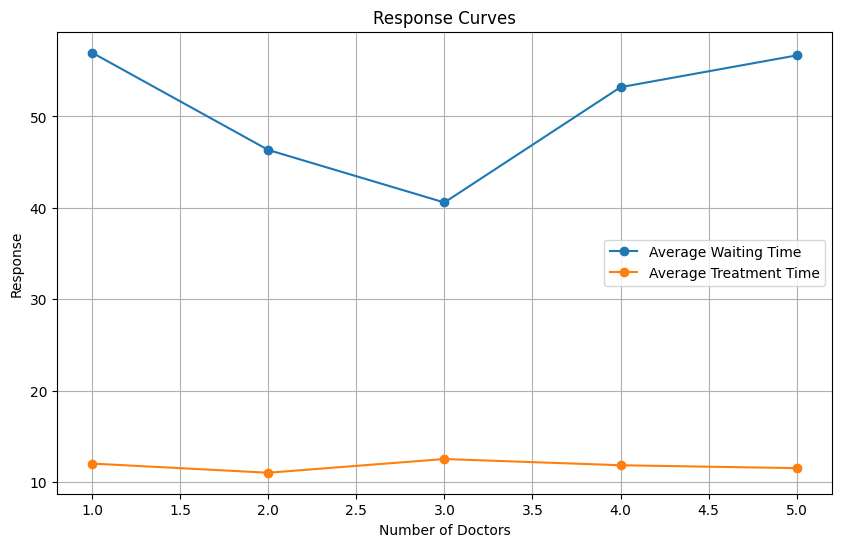

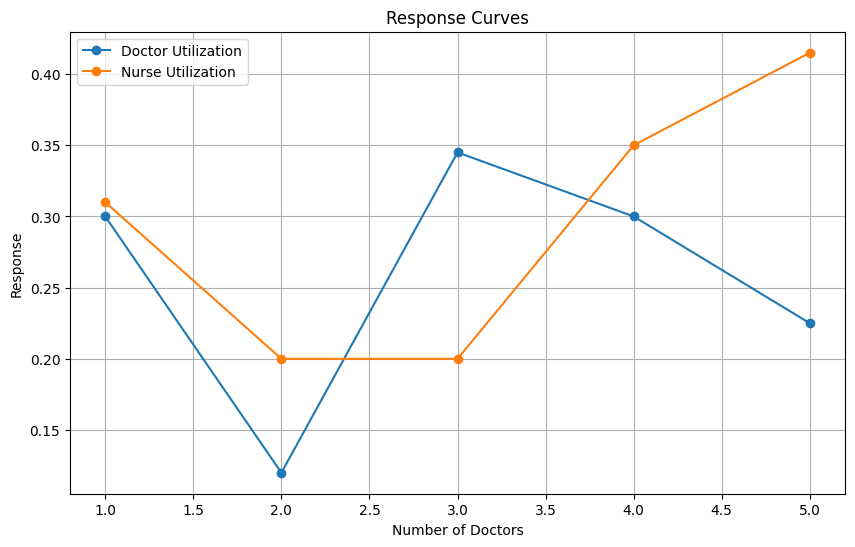

In [17]:
# Perform response surface analysis
def perform_response_surface_analysis():
    # Generate parameter combinations
    parameter_combinations = generate_parameter_combinations()

    # Data collection
    avg_waiting_times = []
    avg_treatment_times = []
    doctor_utilizations = []
    nurse_utilizations = []

    # Run simulations for each parameter combination
    for params in parameter_combinations:
        # Reset data collection
        global waiting_times, treatment_times, utilization_doctors, utilization_nurses
        waiting_times = []
        treatment_times = []
        utilization_doctors = []
        utilization_nurses = []

        # Set up simulation
        env = simpy.Environment()

        # Run simulation
        avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization = run_simulation(env, *params)

        # Collect data
        avg_waiting_times.append(avg_waiting_time)
        avg_treatment_times.append(avg_treatment_time)
        doctor_utilizations.append(doctor_utilization)
        nurse_utilizations.append(nurse_utilization)

    # Plot response curves
    x_values = [p[0] for p in parameter_combinations]

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, avg_waiting_times, marker='o', linestyle='-', label='Average Waiting Time')
    plt.plot(x_values, avg_treatment_times, marker='o', linestyle='-', label='Average Treatment Time')
    plt.xlabel('Number of Doctors')
    plt.ylabel('Response')
    plt.title('Response Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, doctor_utilizations, marker='o', linestyle='-', label='Doctor Utilization')
    plt.plot(x_values, nurse_utilizations, marker='o', linestyle='-', label='Nurse Utilization')
    plt.xlabel('Number of Doctors')
    plt.ylabel('Response')
    plt.title('Response Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simulation
perform_response_surface_analysis()

Patient 1 checked-in at 7.078527744434494
Patient 1 triaged at 12.968601576442538
Patient 1 sees a doctor at 12.968601576442538
Patient 2 checked-in at 22.249394377873653
Patient 1 treated by doctor at 27.968601576442538
Patient 2 triaged at 31.847117885373475
Patient 2 sees a nurse at 31.847117885373475
Patient 2 treated by nurse at 41.84711788537348
Patient 3 checked-in at 43.097231194810895
Patient 4 checked-in at 44.92646524876367
Patient 3 triaged at 51.41049511968719
Patient 3 sees a nurse at 51.41049511968719
Patient 4 triaged at 53.37600571037068
Patient 4 sees a nurse at 53.37600571037068
Patient 3 treated by nurse at 61.41049511968719
Patient 5 checked-in at 62.69414950135424
Patient 4 treated by nurse at 63.37600571037068
Patient 6 checked-in at 69.13072762730849
Patient 7 checked-in at 71.93514267620357
Patient 5 triaged at 73.10893561014741
Patient 5 sees a nurse at 73.10893561014741
Patient 8 checked-in at 74.17405459248552
Patient 6 triaged at 75.28862535870836
Patient 6

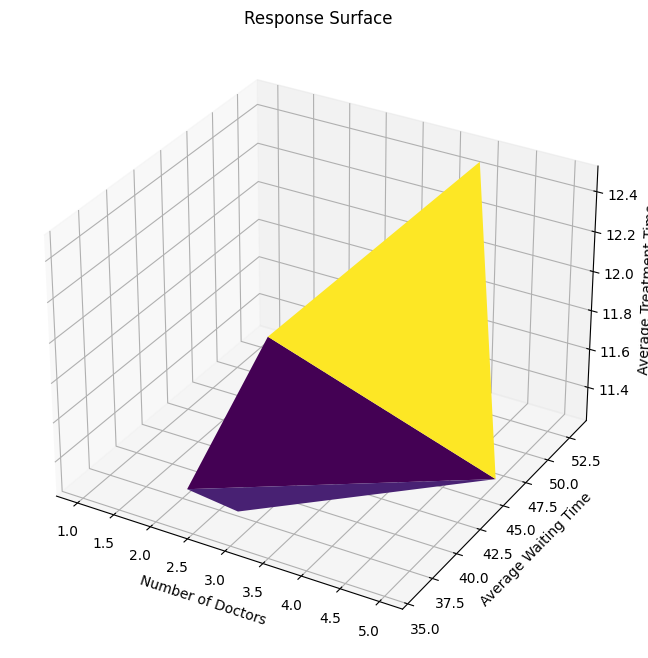

In [18]:
# Perform response surface analysis
def perform_response_surface_analysis():
    # Generate parameter combinations
    parameter_combinations = generate_parameter_combinations()

    # Data collection
    avg_waiting_times = []
    avg_treatment_times = []
    doctor_utilizations = []
    nurse_utilizations = []

    # Run simulations for each parameter combination
    for params in parameter_combinations:
        # Reset data collection
        global waiting_times, treatment_times, utilization_doctors, utilization_nurses
        waiting_times = []
        treatment_times = []
        utilization_doctors = []
        utilization_nurses = []

        # Set up simulation
        env = simpy.Environment()

        # Run simulation
        avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization = run_simulation(env, *params)

        # Collect data
        avg_waiting_times.append(avg_waiting_time)
        avg_treatment_times.append(avg_treatment_time)
        doctor_utilizations.append(doctor_utilization)
        nurse_utilizations.append(nurse_utilization)

    # Plot 3D surface
    x_values = [p[0] for p in parameter_combinations]

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_trisurf(x_values, avg_waiting_times, avg_treatment_times, cmap='viridis', edgecolor='none')

    ax.set_xlabel('Number of Doctors')
    ax.set_ylabel('Average Waiting Time')
    ax.set_zlabel('Average Treatment Time')
    ax.set_title('Response Surface')

    plt.show()

# Run the simulation
perform_response_surface_analysis()